## Sample Analysis

In [42]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

# with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
#     sample_data1 = pickle.load(file)
# print(sample_data1.keys())

# with open('/srv/scratch/z5297792/Sample/500plus_sample_data.pkl', 'rb') as file:
#     sample_data2 = pickle.load(file)
# print(sample_data2.keys())

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
print(the_frontier_eddies)


['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']


In [43]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d


fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

eddy = 'Eddy22' # AE no-tilt # good \
eddy = 'Eddy110' # AE tilt # good off my own analysis \
eddy = 'Eddy134' # CE non-tilt # best \
eddy = 'Eddy133' # CE tilt \
\
eddy = 'Eddy790' # AE non-tilt # best \
eddy = 'Eddy761' # CE non-tilt # not bad \
eddy = 'Eddy749' # CE tilt # good \
eddy = 'Eddy775' # CE tilt # best \
\
The Sample Frontiers: \
\
AE790 no-tilt \
AE110 tilt \
CE134 no-tilt \
CE775 tilt 




## The Frontiers

In [47]:
# cap everything at COWs depth
d_dic = {}
for eddy in the_frontier_eddies:
    d_df = pd.DataFrame()
    for t in range(30):
        df = frontier_sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]
    d_dic[eddy] = d_df


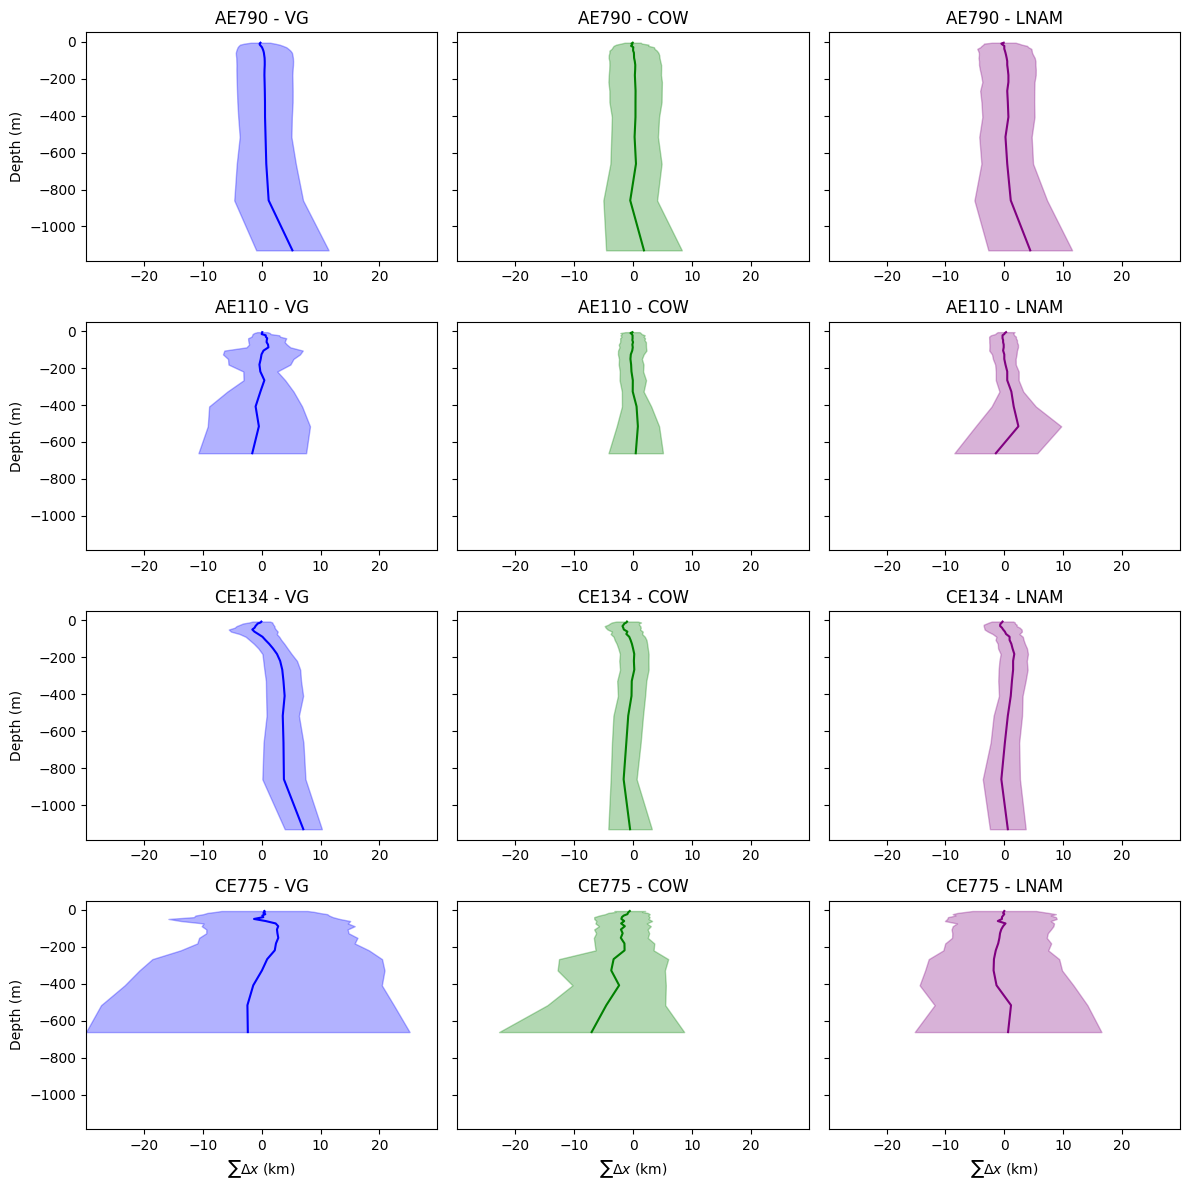

In [83]:
method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]

        x_df = pd.DataFrame()
        for t in range(30):
            x_data = frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']
            max_len = max(len(x_df), len(x_data))
            x_df = x_df.reindex(range(max_len)) 
            x_df[f'T{t}'] = pd.Series(x_data)
        x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
        
        x_mean, x_std = x_df.diff().cumsum().mean(axis=1)/1000, x_df.diff().cumsum().std(axis=1)/1000
        ax.plot(x_mean, z_r[150, 150, :len(x_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(x_mean)], x_mean - x_std, x_mean + x_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta x$ (km)")

        xmin = min(np.nanmin(x_mean - x_std), xmin)
        xmax = max(np.nanmax(x_mean + x_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

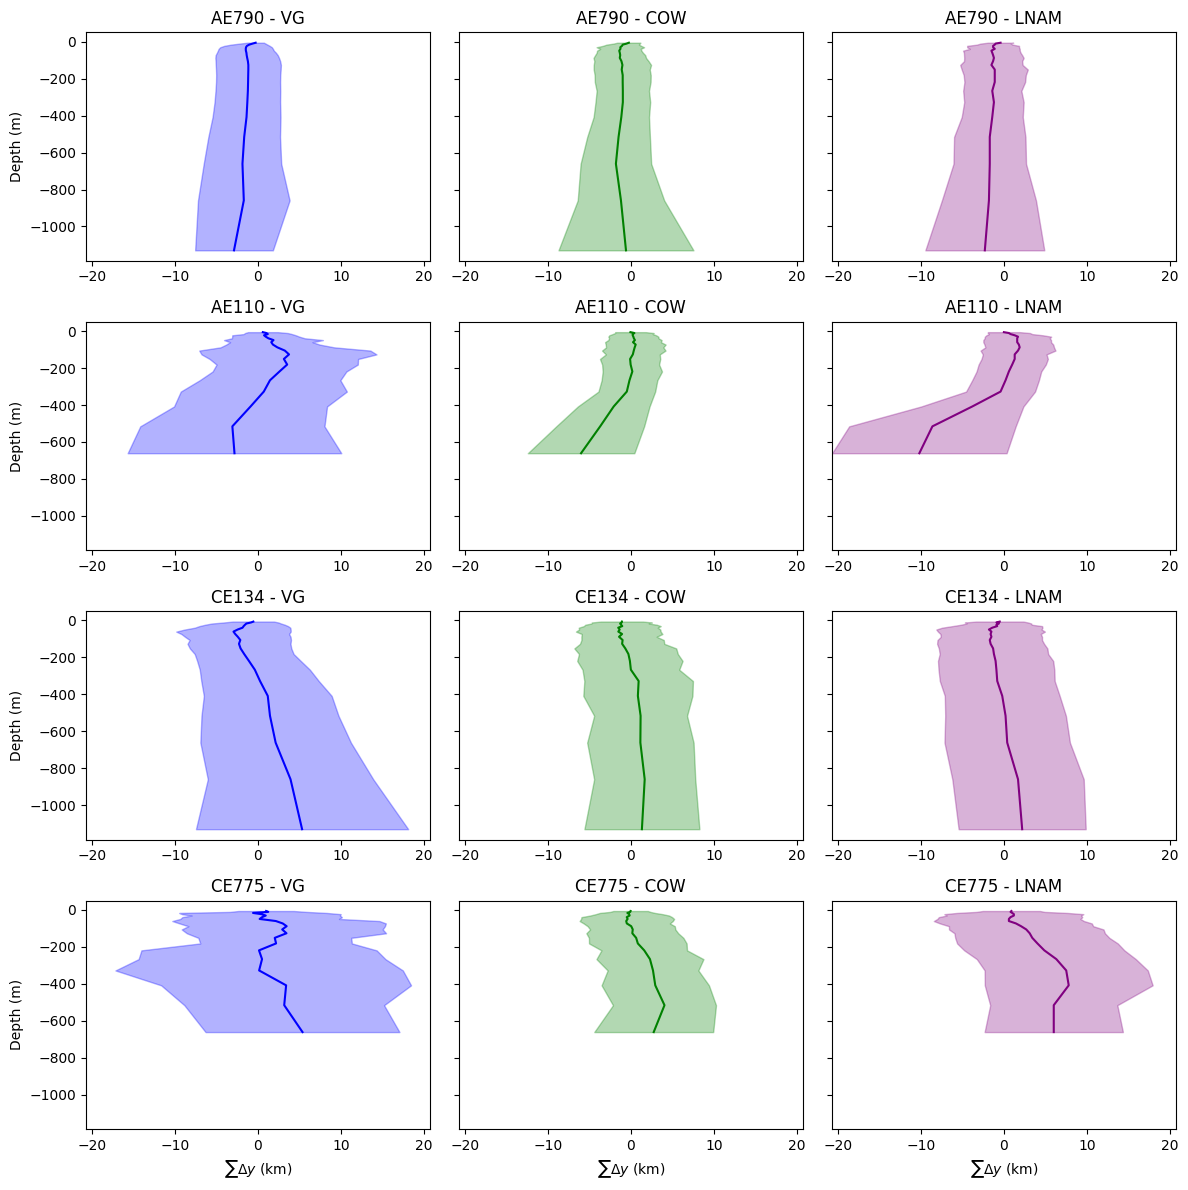

In [84]:
method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        
        y_df = pd.DataFrame()
        for t in range(30):
            y_data = frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']
            max_len = max(len(y_df), len(y_data))
            y_df = y_df.reindex(range(max_len)) 
            y_df[f'T{t}'] = pd.Series(y_data)
        y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs
        
        y_mean, y_std = y_df.diff().cumsum().mean(axis=1)/1000, y_df.diff().cumsum().std(axis=1)/1000
        ax.plot(y_mean, z_r[150, 150, :len(y_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(y_mean)], y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta y$ (km)")

        xmin = min(np.nanmin(y_mean - y_std), xmin)
        xmax = max(np.nanmax(y_mean + y_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

## Covariance Analysis

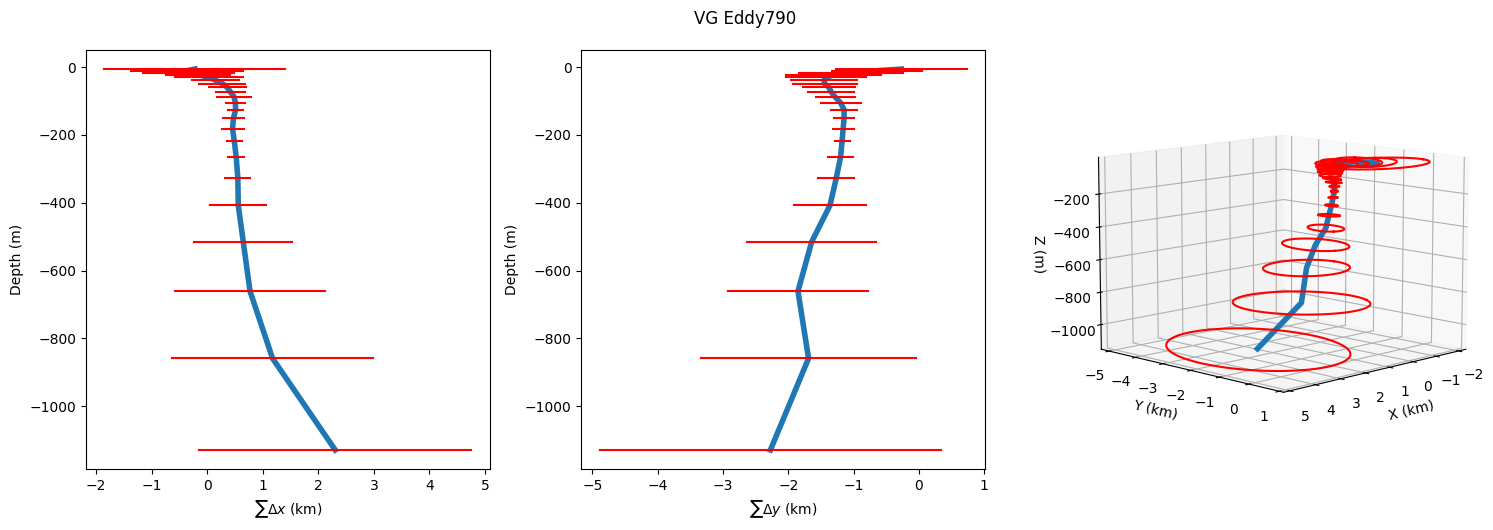

In [86]:
# choose eddy
eddy = the_frontier_eddies[0]

method = 'VG'

# create x and y dataframes 
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
    y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000

    max_len = max(len(x_df), len(x_data))
    x_df = x_df.reindex(range(max_len)) 
    y_df = y_df.reindex(range(max_len))
    x_df[f'T{t}'] = pd.Series(x_data)
    y_df[f'T{t}'] = pd.Series(y_data)
x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

# calcualte covariance matrices
Cz = np.full((2, 2, x_df.shape[0]), np.nan)
for k in range(1, x_df.shape[0]):
    x = x_df.diff().iloc[k]
    x = x.loc[~np.isnan(x)]
    y = y_df.diff().iloc[k]
    y = y.loc[~np.isnan(y)]
    Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
# plot 
x = x_df.diff().mean(axis=1).cumsum()
y = y_df.diff().mean(axis=1).cumsum()
fig = plt.figure(figsize=(15, 5))
ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133, projection='3d')]
ax[0].plot(x, z_r[150, 150, :len(x)], linewidth=4)
ax[1].plot(y, z_r[150, 150, :len(x)], linewidth=4)
ax[2].plot(x, y, z_r[150, 150, :len(x)], linewidth=4)
for k in range(len(x)):
    C = Cz[:, :, k]
    eigvals, eigvecs = np.linalg.eigh(C)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    axis_lengths = np.sqrt(eigvals)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    ellipse_points = rotation_matrix.dot(ellipse_points)
    ax[0].plot([np.min(ellipse_points[0, :] + x[k]), np.max(ellipse_points[0, :] + x[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r')
    ax[1].plot([np.min(ellipse_points[1, :] + y[k]), np.max(ellipse_points[1, :] + y[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r')
    ax[2].plot(ellipse_points[0, :] + x[k], ellipse_points[1, :] + y[k], [z_r[150, 150, k]] * len(ellipse_points[0, :]), color='r')

ax[2].view_init(elev=10, azim=45)
ax[0].set_xlabel(r'$\sum\Delta x$ (km)')
ax[1].set_xlabel(r'$\sum\Delta y$ (km)')
ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_zlabel('Z (m)')
plt.tight_layout()
plt.suptitle(method + ' ' + eddy, y=1.05)
plt.show()



-174.05873516362044
388.55825650447633
376.13798437720357


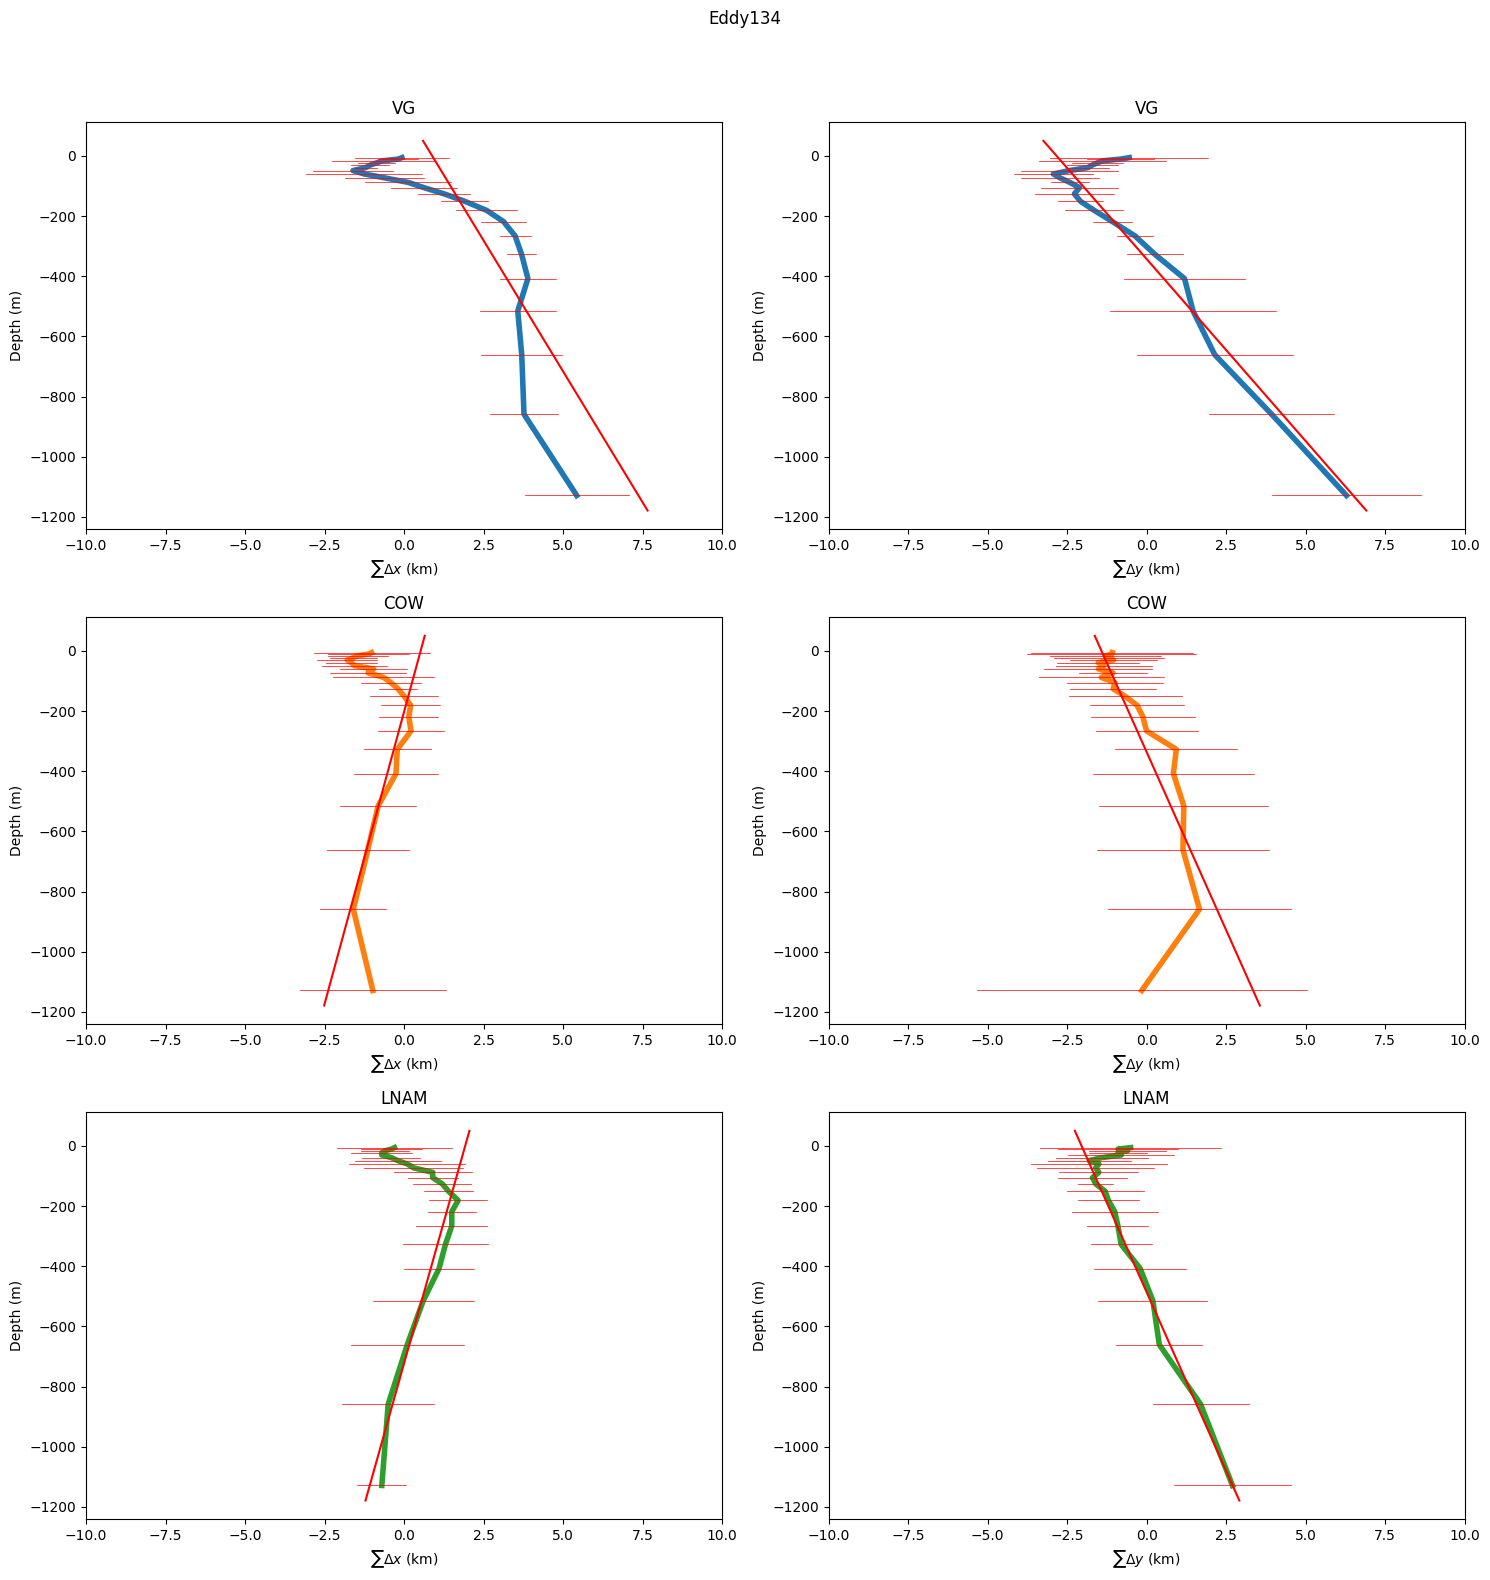

In [143]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid of subplots

eddy = the_frontier_eddies[2]

xmax = 10
xmin = -xmax

colors = plt.cm.tab10.colors
slopes_x, slopes_y = [], []
for row, method in enumerate(['VG', 'COW', 'LNAM']):
    # create x and y dataframes 
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
        y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)
    x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
    y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

    # Calculate covariance matrices
    Cz = np.full((2, 2, x_df.shape[0]), np.nan)
    for k in range(1, x_df.shape[0]):
        x = x_df.diff().iloc[k]
        x = x.loc[~np.isnan(x)]
        y = y_df.diff().iloc[k]
        y = y.loc[~np.isnan(y)]
        Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
    # Plot 
    x = x_df.diff().mean(axis=1).cumsum()
    y = y_df.diff().mean(axis=1).cumsum()
    # Select the row for each method in the 3x2 plot
    ax_x = axes[row, 0]  # X plot
    ax_y = axes[row, 1]  # Y plot
    
    ax_x.plot(x, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    ax_y.plot(y, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    
    # ellipse_areas = []
    x_error = []
    y_error = []
    for k in range(len(x)):
        C = Cz[:, :, k]
        eigvals, eigvecs = np.linalg.eigh(C)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        axis_lengths = np.sqrt(eigvals)
        # ellipse_areas.append(np.pi * axis_lengths[0] * axis_lengths[1]) 
        t = np.linspace(0, 2 * np.pi, 100)
        ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        ellipse_points = rotation_matrix.dot(ellipse_points)
        x_error.append(np.max(ellipse_points[0, :]) - np.min(ellipse_points[0, :]))
        y_error.append(np.max(ellipse_points[1, :]) - np.min(ellipse_points[1, :]))
        # Plot ellipses on the respective axes
        ax_x.plot([np.min(ellipse_points[0, :] + x[k]), np.max(ellipse_points[0, :] + x[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r', linewidth=.5)
        ax_y.plot([np.min(ellipse_points[1, :] + y[k]), np.max(ellipse_points[1, :] + y[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r', linewidth=.5)

    # Interpolation and polynomial fit logic (unchanged)
    wx = x_error[1:]
    wy = y_error[1:]
    x = x[1:]
    y = y[1:]
    z = z_r[150, 150, 1:len(x)+1]
    # Interpolation and polynomial fitting process
    wx_original = wx
    wy_original = wy
    x_original = x
    y_original = y
    z_original = z
    z_new = np.flip(np.linspace(np.min(z), np.max(z), num=len(z)))
    interpolate_func = interp1d(z_original, wx_original, kind='linear', fill_value="extrapolate")
    wx_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, wy_original, kind='linear', fill_value="extrapolate")
    wy_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
    x_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
    y_new = interpolate_func(z_new)
    wx = 1/wx_new
    wy = 1/wy_new
    x = x_new
    y = y_new
    z = z_new
    
    z_top = 50
    z_btm = z[-1] - 50
    coefficients_x = np.polyfit(x, z, 1, w=wx)
    slope_x, intercept_x = coefficients_x
    print(slope_x)
    slopes_x.append(slope_x)
    coefficients_y = np.polyfit(y, z, 1, w=wy)
    slope_y, intercept_y = coefficients_y
    slopes_y.append(slope_y)
    x_btm = (z_btm - intercept_x) / slope_x
    x_top = (z_top - intercept_x) / slope_x
    y_btm = (z_btm - intercept_y) / slope_y
    y_top = (z_top - intercept_y) / slope_y
    ax_x.plot([x_btm, x_top], [z_btm, z_top], color='red')
    ax_y.plot([y_btm, y_top], [z_btm, z_top], color='red')
    ax_x.set_xlabel(r'$\sum\Delta x$ (km)')
    ax_y.set_xlabel(r'$\sum\Delta y$ (km)')
    ax_x.set_ylabel('Depth (m)')
    ax_y.set_ylabel('Depth (m)')
    ax_x.set_title(f'{method}')
    ax_y.set_title(f'{method}')
    ax_x.set_xlim([xmin, xmax])
    ax_y.set_xlim([xmin, xmax])
    
plt.tight_layout()
plt.suptitle(f'{eddy}', y=1.05)
plt.show()


In [90]:
methods = ['VG', 'COW', 'LNAM']
X_slope = pd.DataFrame(columns=methods)
Y_slope = pd.DataFrame(columns=methods)

for eddy in the_frontier_eddies:
    dfx = pd.DataFrame()
    dfy = pd.DataFrame()
    for method in methods:
        # create x and y dataframes 
        x_df = pd.DataFrame()
        y_df = pd.DataFrame()
        for t in range(30):
            x_data = (frontier_sample_data[eddy][f'T{t}'][method]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
            y_data = (frontier_sample_data[eddy][f'T{t}'][method]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000
        
            max_len = max(len(x_df), len(x_data))
            x_df = x_df.reindex(range(max_len)) 
            y_df = y_df.reindex(range(max_len))
            x_df[f'T{t}'] = pd.Series(x_data)
            y_df[f'T{t}'] = pd.Series(y_data)
        x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
        y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs        
        
        # Calculate covariance matrices
        Cz = np.full((2, 2, x_df.shape[0]), np.nan)
        for k in range(1, x_df.shape[0]):
            x = x_df.diff().iloc[k]
            x = x.loc[~np.isnan(x)]
            y = y_df.diff().iloc[k]
            y = y.loc[~np.isnan(y)]
            Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
        x = x_df.diff().mean(axis=1).cumsum()
        y = y_df.diff().mean(axis=1).cumsum()
        x_error = []
        y_error = []
        for k in range(len(x)):
            C = Cz[:, :, k]
            eigvals, eigvecs = np.linalg.eigh(C)
            order = eigvals.argsort()[::-1]
            eigvals, eigvecs = eigvals[order], eigvecs[:, order]
            angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
            axis_lengths = np.sqrt(eigvals)
            t = np.linspace(0, 2 * np.pi, 100)
            ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
            rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
            ellipse_points = rotation_matrix.dot(ellipse_points)
            x_error.append(np.max(ellipse_points[0, :]) - np.min(ellipse_points[0, :]))
            y_error.append(np.max(ellipse_points[1, :]) - np.min(ellipse_points[1, :]))
        # Interpolation and polynomial fit logic 
        wx = x_error[1:]
        wy = y_error[1:]
        x = x[1:]
        y = y[1:]
        z = z_r[150, 150, 1:len(x)+1]
        # Interpolation and polynomial fitting process
        wx_original = wx
        wy_original = wy
        x_original = x
        y_original = y
        z_original = z
        z_new = np.flip(np.linspace(np.min(z), np.max(z), num=100))
        interpolate_func = interp1d(z_original, wx_original, kind='linear', fill_value="extrapolate")
        wx_new = interpolate_func(z_new)
        interpolate_func = interp1d(z_original, wy_original, kind='linear', fill_value="extrapolate")
        wy_new = interpolate_func(z_new)
        interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
        x_new = interpolate_func(z_new)
        interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
        y_new = interpolate_func(z_new)
        wx = 1/wx_new
        wy = 1/wy_new
        x = x_new
        y = y_new
        z = z_new
    
        coefficients_x = np.polyfit(x, z, 1, w=wx)
        slope_x, intercept_x = coefficients_x
        coefficients_y = np.polyfit(y, z, 1, w=wy)
        slope_y, intercept_y = coefficients_y

        dfx[method] = [slope_x/1000]
        dfy[method] = [slope_y/1000]
    
    X_slope.loc[eddy] = dfx.iloc[0]
    Y_slope.loc[eddy] = dfy.iloc[0]


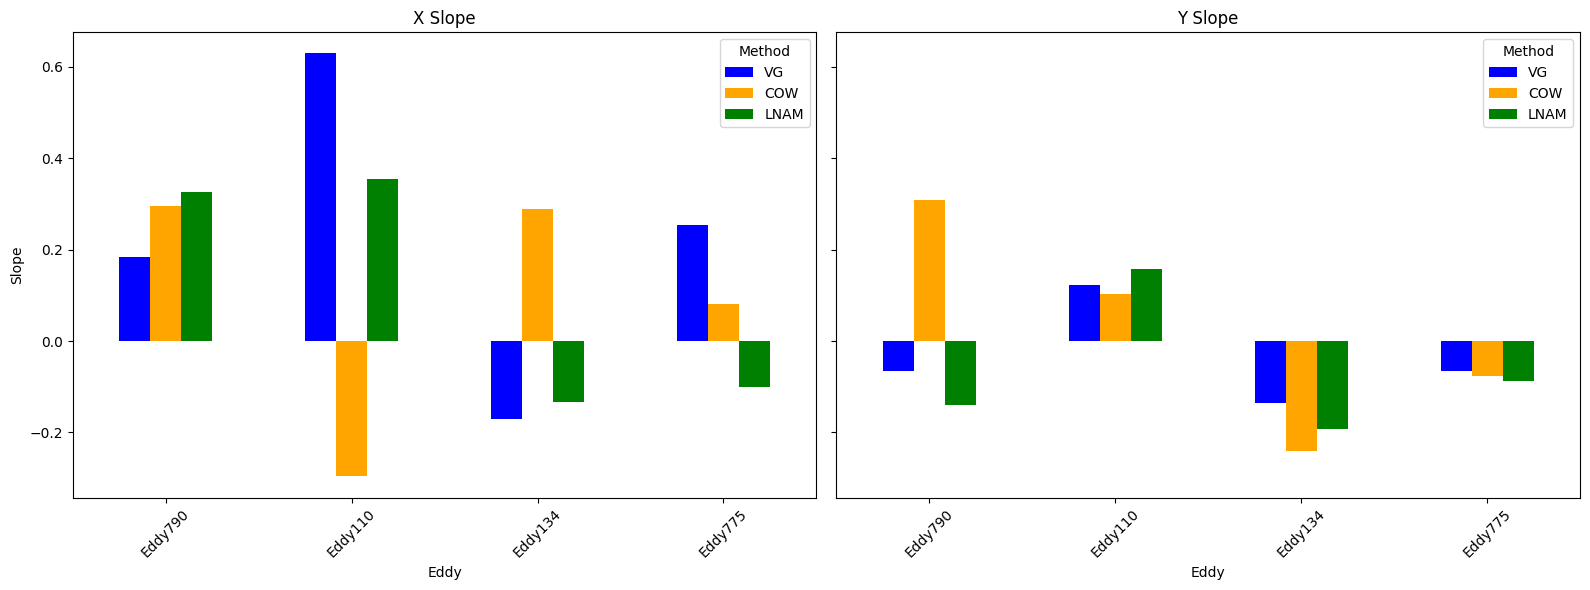

In [91]:

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot X_slope in the first subplot
X_slope.plot(kind='bar', ax=axes[0], color=["blue", "orange", "green"])
axes[0].set_title("X Slope")
axes[0].set_xlabel("Eddy")
axes[0].set_ylabel("Slope")
axes[0].legend(title="Method")
axes[0].tick_params(axis='x', rotation=45)

# Plot Y_slope in the second subplot
Y_slope.plot(kind='bar', ax=axes[1], color=["blue", "orange", "green"])
axes[1].set_title("Y Slope")
axes[1].set_xlabel("Eddy")
axes[1].legend(title="Method")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



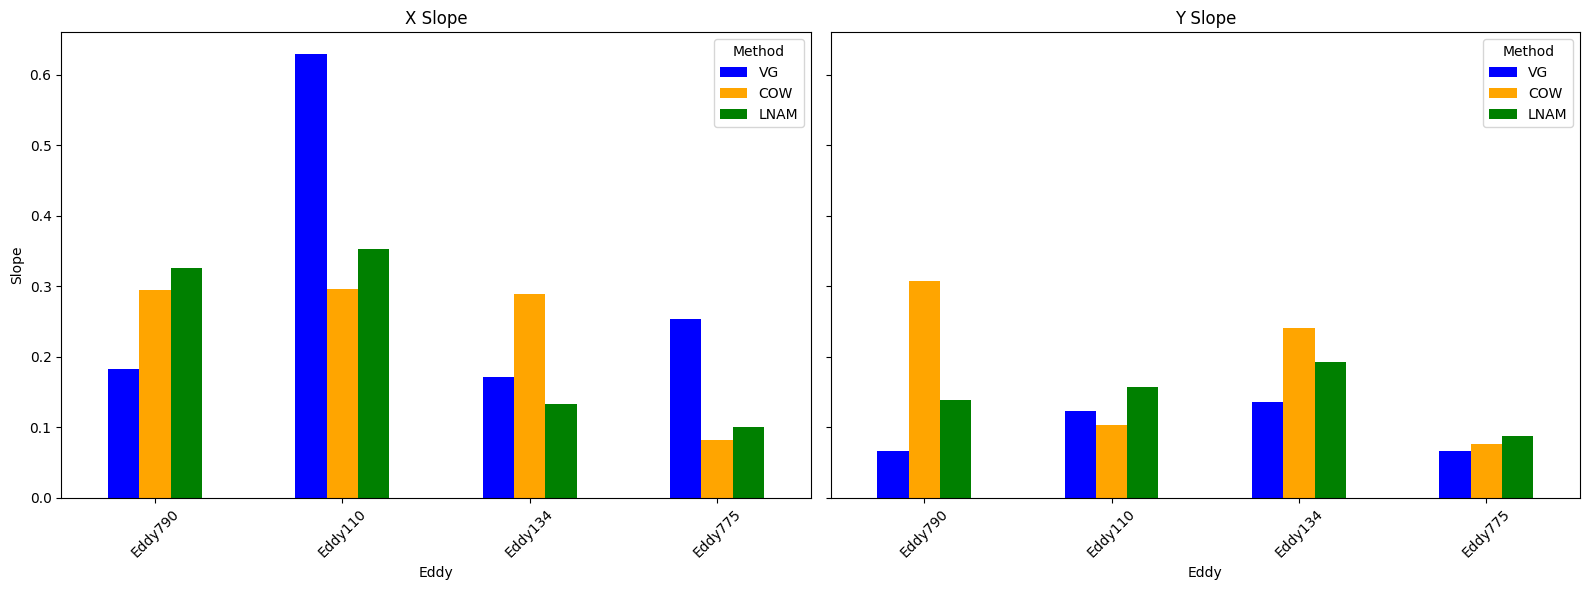

In [92]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot X_slope in the first subplot
abs(X_slope).plot(kind='bar', ax=axes[0], color=["blue", "orange", "green"])
axes[0].set_title("X Slope")
axes[0].set_xlabel("Eddy")
axes[0].set_ylabel("Slope")
axes[0].legend(title="Method")
axes[0].tick_params(axis='x', rotation=45)

# Plot Y_slope in the second subplot
abs(Y_slope).plot(kind='bar', ax=axes[1], color=["blue", "orange", "green"])
axes[1].set_title("Y Slope")
axes[1].set_xlabel("Eddy")
axes[1].legend(title="Method")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


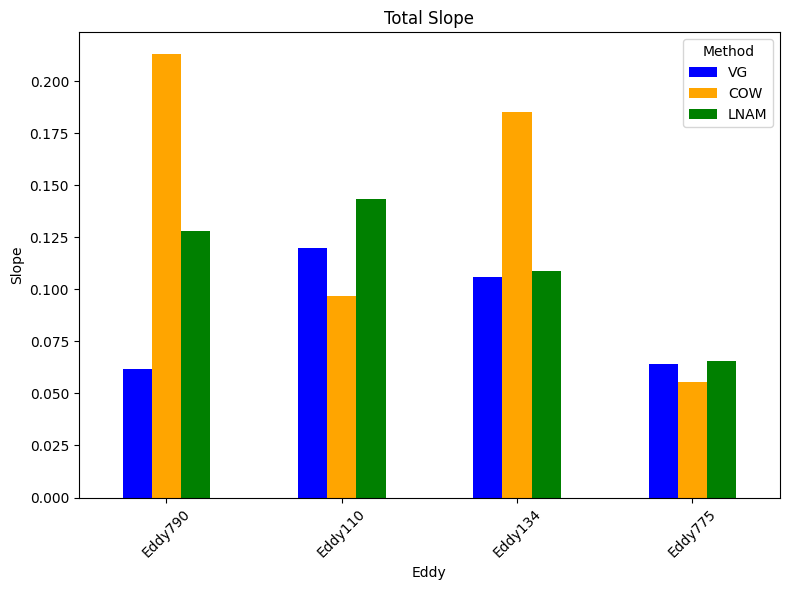

In [93]:
T_slope = abs((X_slope * Y_slope) / np.sqrt(X_slope**2 + Y_slope**2))

ax = T_slope.plot(kind='bar', figsize=(8, 6), color=["blue", "orange", "green"])
ax.set_title("Total Slope")
ax.set_xlabel("Eddy")
ax.set_ylabel("Slope")
plt.legend(title="Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Greater the slope, the smaller the tilt

In [12]:
T_slope

,VG,COW,LNAM
Eddy790,0.535642,0.027375,0.400933
Eddy110,0.048282,0.097019,0.049797
Eddy134,0.087668,0.185221,0.129604
Eddy775,0.042422,0.065029,0.052966


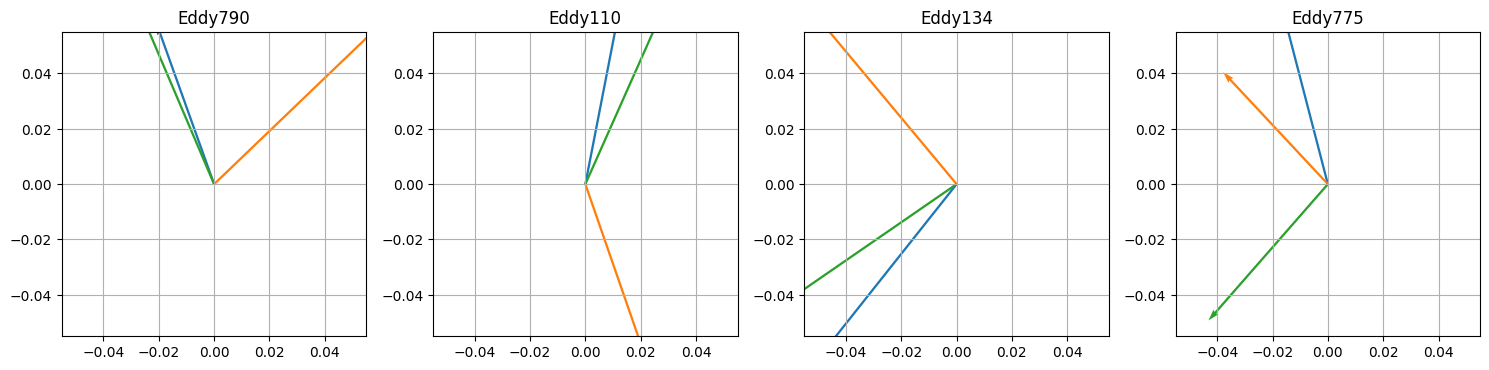

In [94]:
TiltDir = np.degrees(np.arctan2(Y_slope, X_slope)) % 360

fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # 1x3 subplot grid

for idx, eddy in enumerate(the_frontier_eddies):
    Tdiss = T_slope.loc[eddy]
    Tdirs = TiltDir.loc[eddy]
    
    colors = plt.cm.tab10.colors
    i = 0
    for Tdis, Tdir in zip(Tdiss, Tdirs):
        Tdir_cartesian = 90 - Tdir
        Tdir_rad = np.radians(Tdir_cartesian)
        
        u = Tdis * np.cos(Tdir_rad)
        v = Tdis * np.sin(Tdir_rad)
        
        axs[idx].quiver(0, 0, u, v, angles='xy', scale_units='xy', scale=1, color=colors[i])
        i += 1
        
    axs[idx].set_aspect('equal', adjustable='box')
    axs[idx].grid()
    axs[idx].set_title(f"{eddy}")  # Optional: add title for each subplot

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

## Birds Eye View

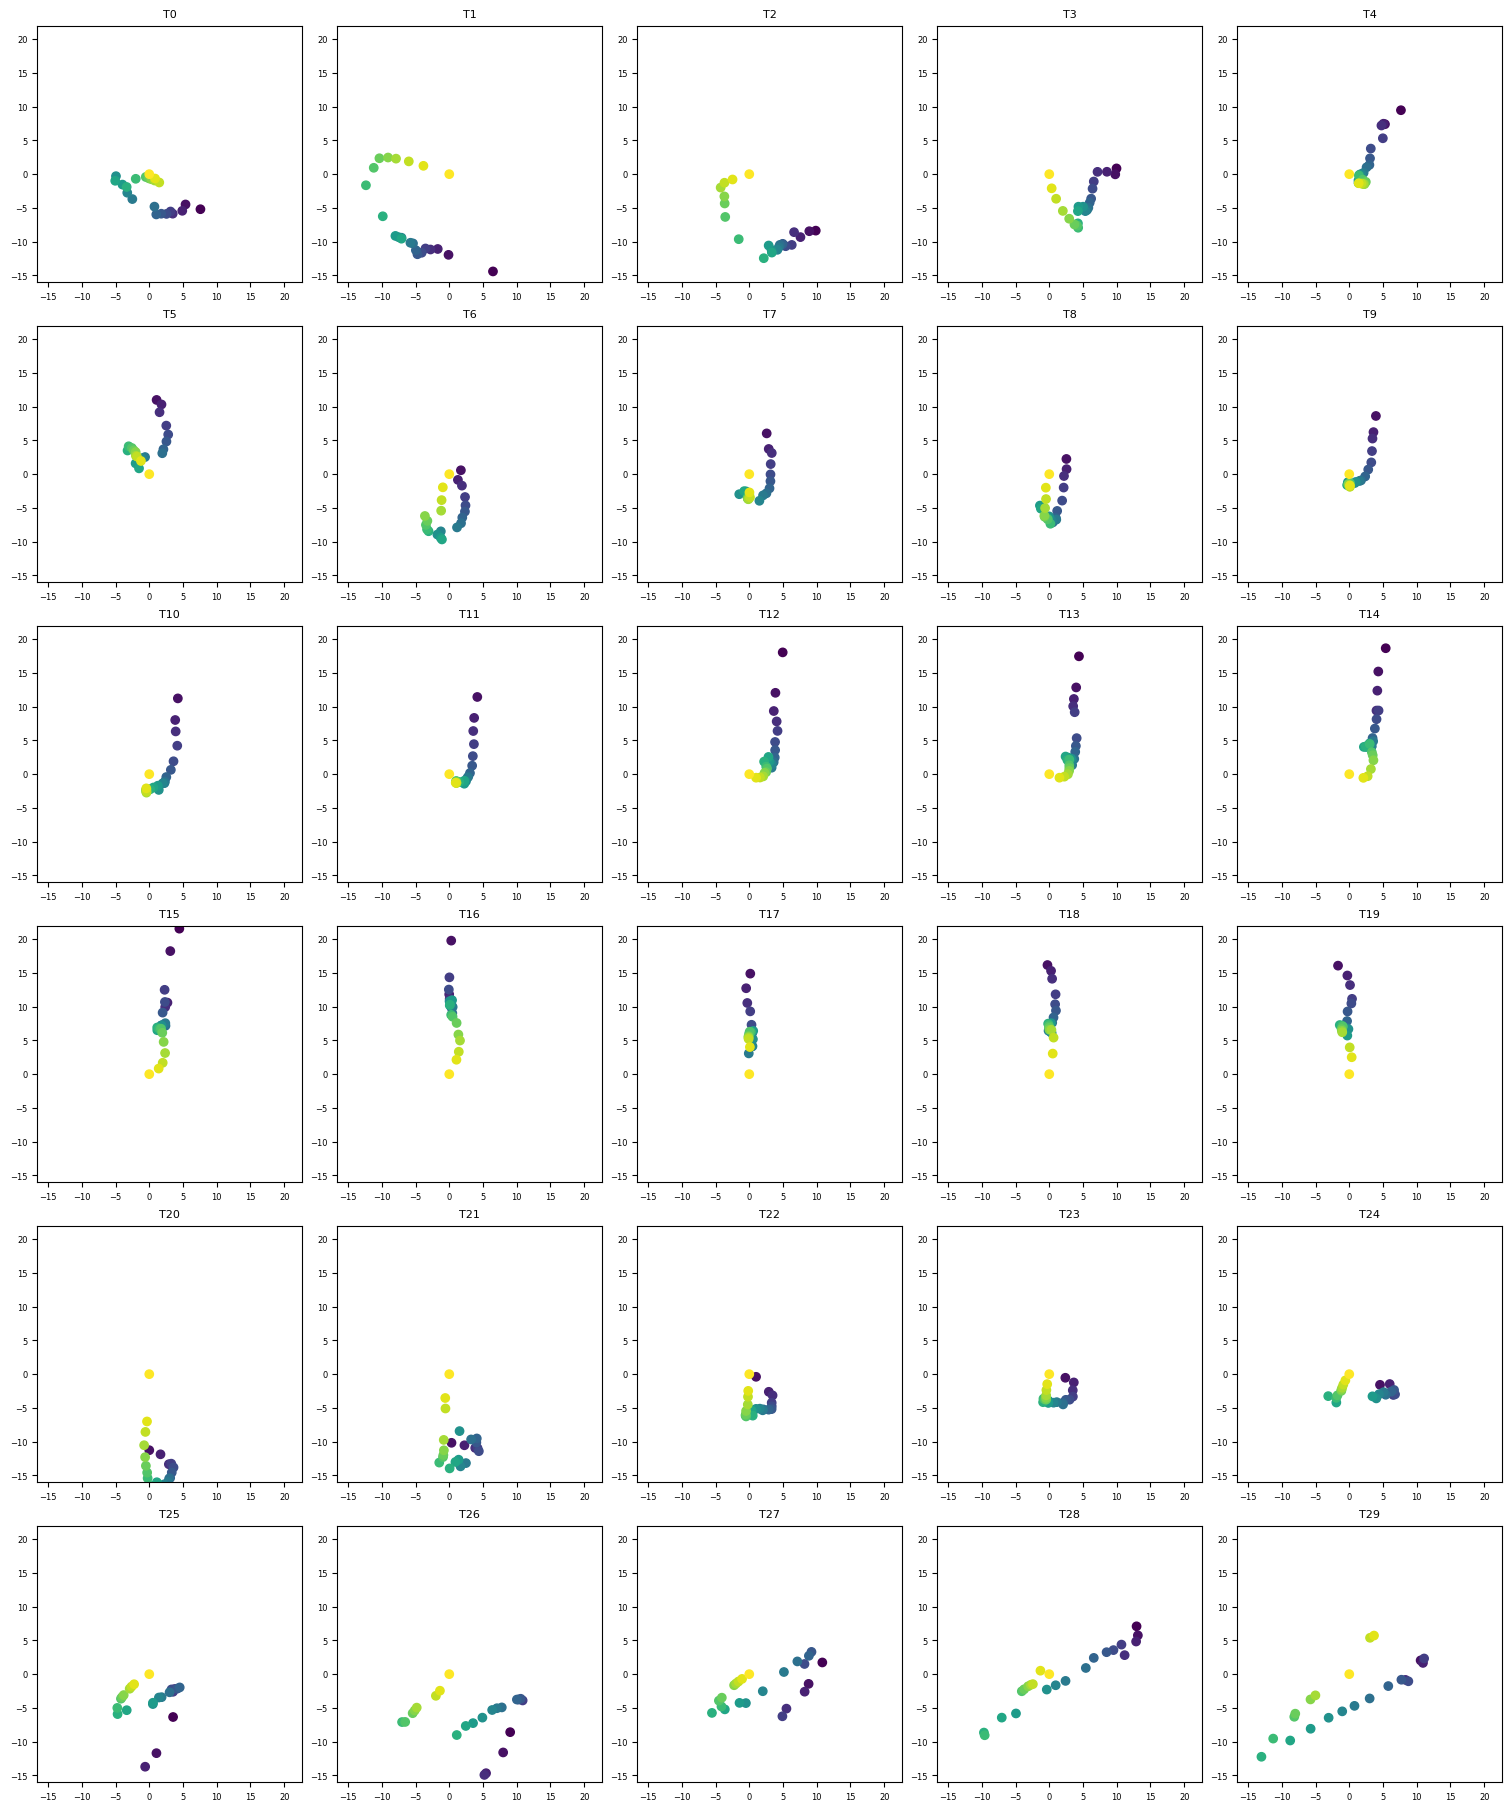

In [14]:
eddy = the_frontier_eddies[2]
fig, axes = plt.subplots(6, 5, figsize=(15, 18), constrained_layout=True)
method = 'VG'
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_data = (sample_data[eddy][f'T{t}'][method]['x'] - sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
    y_data = (sample_data[eddy][f'T{t}'][method]['y'] - sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000

    max_len = max(len(x_df), len(x_data))
    x_df = x_df.reindex(range(max_len)) 
    y_df = y_df.reindex(range(max_len))
    x_df[f'T{t}'] = pd.Series(x_data)
    y_df[f'T{t}'] = pd.Series(y_data)

Deltax = x_df.diff().cumsum()
Deltay = y_df.diff().cumsum()

x_min, x_max = x_df.min().min(), x_df.max().max()
y_min, y_max = y_df.min().min(), y_df.max().max()
lim_min, lim_max = min(x_min, y_min), max(x_max, y_max)  

cmap = plt.cm.viridis

for t in range(30):
    ax = axes[t // 5, t % 5]
    n_points = len(x_df[f'T{t}'])
    colors = cmap(np.linspace(0, 1, n_points))
    ax.scatter(x_df[f'T{t}'].iloc[::-1], y_df[f'T{t}'].iloc[::-1], color=colors)
    ax.set_title(f"T{t}", fontsize=8)
    ax.axis('equal')
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.tick_params(labelsize=6)
plt.show()

# light color at the top!

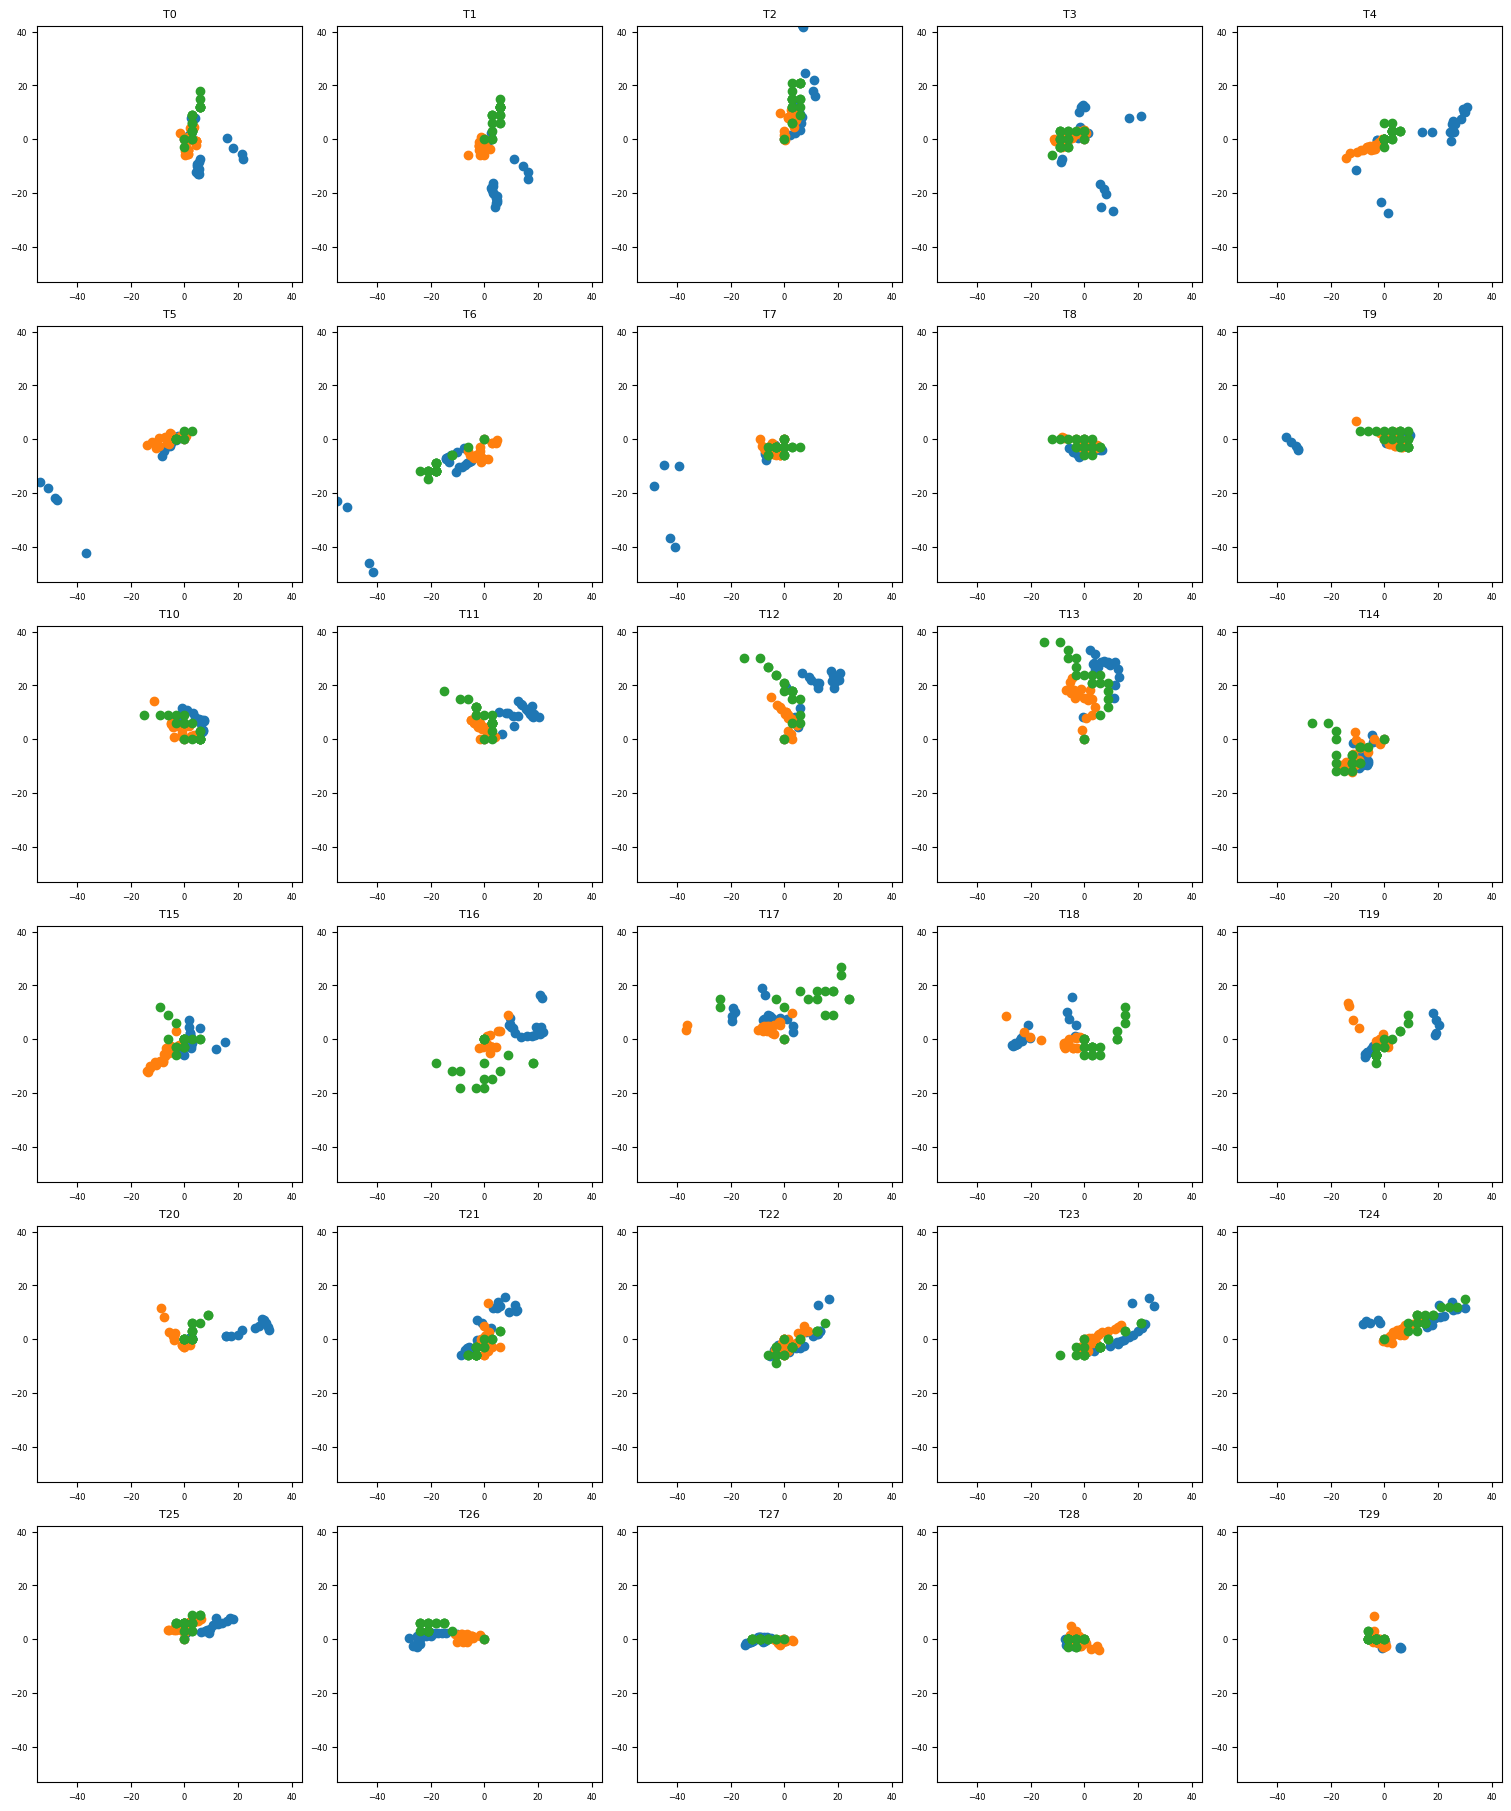

In [15]:
eddy = the_frontier_eddies[3]
fig, axes = plt.subplots(6, 5, figsize=(15, 18), constrained_layout=True)
xmin, xmax = 0, 0
ymin, ymax = 0, 0
for method in ['VG', 'COW', 'LNAM']:
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (sample_data[eddy][f'T{t}'][method]['x'] - sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
        y_data = (sample_data[eddy][f'T{t}'][method]['y'] - sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)    
        
    Deltax = x_df.diff().cumsum()
    Deltay = y_df.diff().cumsum()
    
    x_min, x_max = x_df.min().min(), x_df.max().max()
    y_min, y_max = y_df.min().min(), y_df.max().max()
    
    xmin, xmax = min(xmin, x_min), max(xmax, x_max)
    ymin, ymax = min(ymin, y_min), max(ymax, y_max)

    lim_min, lim_max = min(xmin, ymin), max(xmax, ymax)  
    
    cmap = plt.cm.viridis
    
    for t in range(30):
        ax = axes[t // 5, t % 5]
        n_points = len(x_df[f'T{t}'])
        colors = cmap(np.linspace(0, 1, n_points))
        ax.scatter(x_df[f'T{t}'].iloc[::-1], y_df[f'T{t}'].iloc[::-1])#, color=colors)
        ax.set_title(f"T{t}", fontsize=8)
        ax.axis('equal')
        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)
        ax.tick_params(labelsize=6)

plt.show()

## Depth

In [16]:
H_dic = {}
for eddy in the_frontier_eddies:
    H_df = pd.DataFrame()
    for method in ['VG', 'COW', 'LNAM']:
        Hs = []
        for t in range(30):
            Hs.append(z_r[150,150,len(frontier_sample_data[eddy]['T'+str(t)][method])-1])
        H_df[method] = Hs
    H_dic[eddy] = H_df

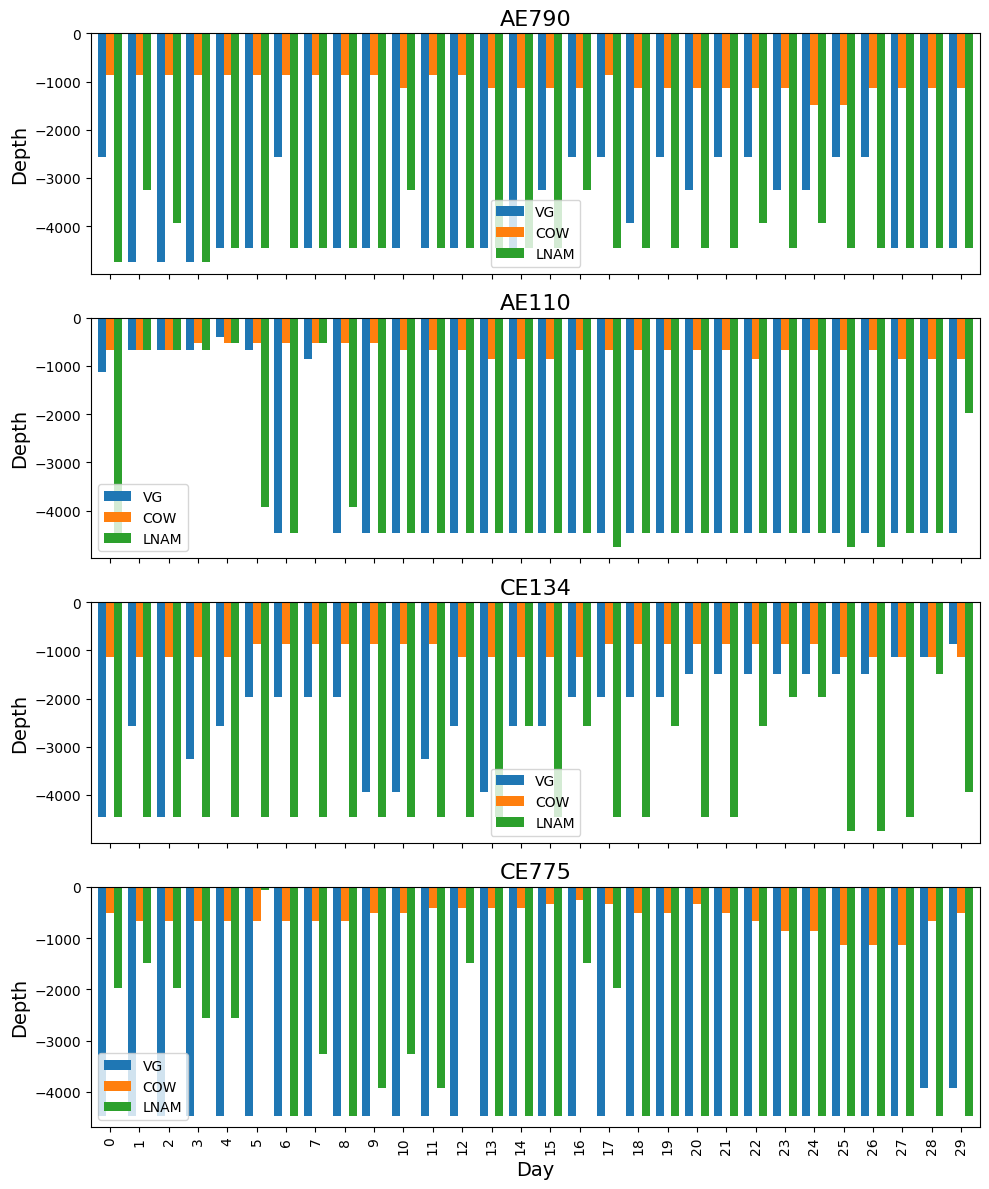

In [17]:
latex_names = ['AE790', 'AE110', 'CE134', 'CE775']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), sharex=True)  
for i, eddy in enumerate(the_frontier_eddies):
    ax = axes[i] 
    (H_dic[eddy]).plot(kind='bar', ax=ax, width=0.8)  
    ax.set_title(latex_names[i], fontsize=16) 
    ax.set_ylabel('Depth', fontsize=14)  
    if i == 3:
        ax.set_xlabel('Day', fontsize=14)  

plt.tight_layout() 
plt.show()


## VG Vorticity

In [126]:
with open('/srv/scratch/z5297792/Sample/VG_vort.pkl', 'rb') as file:
    VG_vort = pickle.load(file)

for eddy in the_frontier_eddies:
    for t in range(30):
        VG_vort[eddy].iloc[d_dic[eddy]['T'+str(t)][0]:, t] = np.nan
    VG_vort[eddy] = VG_vort[eddy].dropna(how='all')
    

In [140]:
for eddy in the_frontier_eddies:
    last_non_nan = VG_vort[eddy].apply(lambda col: col[col.last_valid_index()])
    print(eddy +' '+str(last_non_nan.mean()))

Eddy790 6.438046328270836e-06
Eddy110 6.713377177226845e-06
Eddy134 -6.810483099598699e-06
Eddy775 -6.251704299951128e-06


In [141]:
VG_vort[eddy]

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,-0.000026,-0.000024,-0.000023,-0.000024,-0.000018,-0.000021,-0.000021,-0.000020,-0.000020,-0.000018,...,-0.000020,-0.000020,-0.000018,-0.000016,-0.000013,-0.000015,-0.000017,-0.000018,-0.000020,-0.000020
1,-0.000026,-0.000024,-0.000023,-0.000023,-0.000019,-0.000021,-0.000021,-0.000020,-0.000020,-0.000018,...,-0.000020,-0.000019,-0.000018,-0.000016,-0.000015,-0.000015,-0.000017,-0.000018,-0.000019,-0.000020
2,-0.000026,-0.000023,-0.000022,-0.000023,-0.000019,-0.000021,-0.000021,-0.000020,-0.000020,-0.000019,...,-0.000020,-0.000019,-0.000018,-0.000016,-0.000014,-0.000015,-0.000017,-0.000018,-0.000019,-0.000020
3,-0.000026,-0.000023,-0.000021,-0.000017,-0.000019,-0.000021,-0.000021,-0.000020,-0.000020,-0.000019,...,-0.000019,-0.000019,-0.000018,-0.000017,-0.000014,-0.000015,-0.000017,-0.000018,-0.000019,-0.000020
4,-0.000026,-0.000023,-0.000021,-0.000017,-0.000018,-0.000021,-0.000021,-0.000020,-0.000020,-0.000018,...,-0.000019,-0.000019,-0.000018,-0.000017,-0.000014,-0.000015,-0.000017,-0.000018,-0.000019,-0.000019
5,-0.000025,-0.000022,-0.000020,-0.000022,-0.000018,-0.000021,-0.000021,-0.000020,-0.000020,-0.000018,...,-0.000018,-0.000018,-0.000018,-0.000017,-0.000014,-0.000015,-0.000017,-0.000018,-0.000019,-0.000020
6,-0.000024,-0.000022,-0.000019,-0.000023,-0.000018,-0.000021,-0.000021,-0.000020,-0.000020,-0.000018,...,-0.000018,-0.000018,-0.000018,-0.000017,-0.000014,-0.000015,-0.000017,-0.000018,-0.000019,-0.000020
7,-0.000024,-0.000022,-0.000019,-0.000022,-0.000018,-0.000020,-0.000021,-0.000020,-0.000019,-0.000017,...,-0.000018,-0.000018,-0.000017,-0.000016,-0.000014,-0.000015,-0.000015,-0.000018,-0.000019,-0.000019
8,-0.000024,-0.000021,-0.000019,-0.000022,-0.000019,-0.000020,-0.000020,-0.000019,-0.000019,-0.000017,...,-0.000018,-0.000017,-0.000017,-0.000016,-0.000014,-0.000014,-0.000015,-0.000017,-0.000019,-0.000019
9,-0.000024,-0.000021,-0.000019,-0.000021,-0.000018,-0.000019,-0.000019,-0.000019,-0.000018,-0.000018,...,-0.000017,-0.000017,-0.000016,-0.000016,-0.000014,-0.000014,-0.000015,-0.000018,-0.000019,-0.000019


In [128]:
method = 'VG'

TD_dic = {}
for eddy in the_frontier_eddies:
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
        y_data = (frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)
        
    TD_dic[eddy] = np.hypot(x_df, y_df)

Text(0.5, 0, 'Tilt Distance')

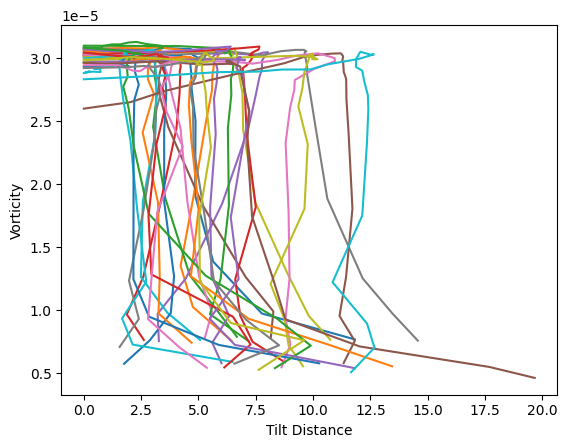

In [129]:
eddy = the_frontier_eddies[0]
for t in range(30):
    TD = TD_dic[eddy]['T'+str(t)]
    v = VG_vort[eddy]['T'+str(t)][:len(TD)]
    plt.plot(TD, v)
plt.ylabel('Vorticity')
plt.xlabel('Tilt Distance')

Text(0.5, 0, 'Tilt Distance')

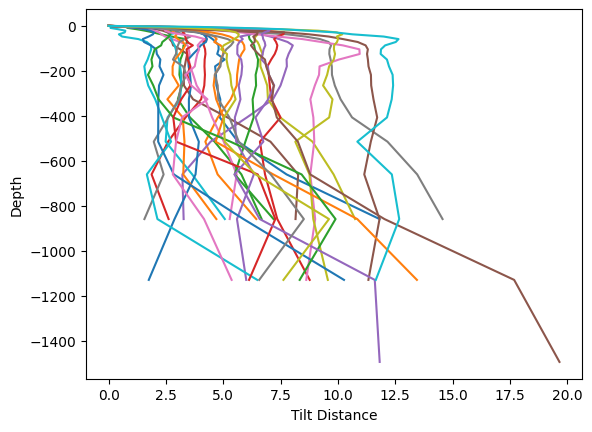

In [130]:
eddy = the_frontier_eddies[0]
for t in range(30):
    TD = TD_dic[eddy]['T'+str(t)]
    z = z_r[150, 150, :len(TD)]
    plt.plot(TD, z)
plt.ylabel('Depth')
plt.xlabel('Tilt Distance')

Text(0.5, 0, 'Vorticity')

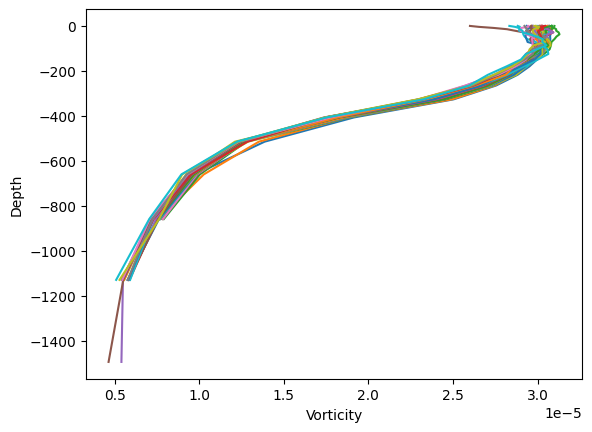

In [131]:
eddy = the_frontier_eddies[0]
for t in range(30):
    TD = TD_dic[eddy]['T'+str(t)]
    v = VG_vort[eddy]['T'+str(t)][:len(TD)]
    z = z_r[150, 150, :len(TD)]
    plt.plot(v, z)
plt.ylabel('Depth')
plt.xlabel('Vorticity')